# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [62]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

np.random.seed(42)
random.seed(42)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [2]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [4]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [5]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [6]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [7]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0013107467674774997

## Entropy

In [8]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [9]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [10]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [11]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [12]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [13]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [14]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [15]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [16]:
# model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

In [17]:
# model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [18]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [19]:
## to have 60-20-20 split, we split into train and validation, and then train would be split into train and test
x_train, x_val, y_train, y_val = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=42) ## test 0.8*.25 =0.2

In [20]:
len_train, len_test, len_val = len(x_train), len(x_test), len(x_val)
assert len(df) == (len_train + len_test + len_val)
print(
    f'train/test/validation: {round(len_train / len(df) *100,0)}, {round(len_test / len(df) *100,0)}, {round(len_val / len(df) *100,0)}'
)

train/test/validation: 60.0, 20.0, 20.0


**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

#### Round 1

*n_estimators*

<AxesSubplot:ylabel='Accuracy'>

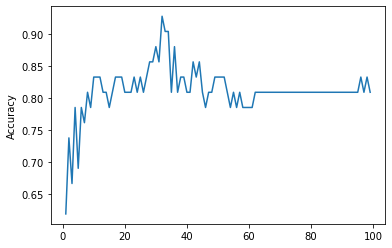

In [21]:
accuracy_ = []
for i in range(1, 100):
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy_.append(accuracy_score(y_test, y_pred))
data = pd.DataFrame(accuracy_, index=range(1, 100), columns=['Accuracy'])
sns.lineplot(x=data.index, y="Accuracy", data=data)

In [22]:
data.idxmax() #n_estimators with max accuracy

Accuracy    32
dtype: int64

*split criterion*

In [23]:
model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_gini = accuracy_score(y_test, y_pred)

model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='entropy')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_entropy = accuracy_score(y_test, y_pred)

In [24]:
accuracy_gini #gini as a splut criterion shows higher accuracy

0.9285714285714286

In [25]:
accuracy_entropy

0.8095238095238095

*# max_depth*

In [26]:
accuracy_ = []
ix = []
for i in range(0, 50):
    if i == 0:
        model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=None)
        ix.append(None)
    else:
        model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=i)
        ix.append(i)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy_.append(accuracy_score(y_test, y_pred))

<AxesSubplot:xlabel='max_depth', ylabel='accuracy'>

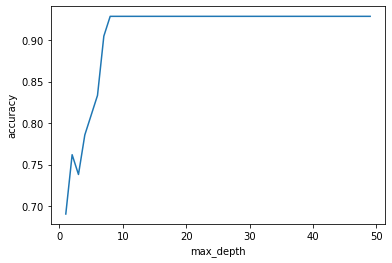

In [27]:
data = pd.DataFrame(list(zip(ix,accuracy_)), columns=['max_depth', 'accuracy'])
sns.lineplot(x='max_depth', y="accuracy", data=data)

In [28]:
data.head(10) #highets accuracy starting from max_depth 8

,max_depth,accuracy
0,NaN,0.928571
1,1.0,0.690476
2,2.0,0.761905
3,3.0,0.738095
4,4.0,0.785714
5,5.0,0.809524
6,6.0,0.833333
7,7.0,0.904762
8,8.0,0.928571
9,9.0,0.928571


*min_samples_split*

In [29]:
accuracy_ = []
ix = []
for i in range(2, 100):
    model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=8, min_samples_split=i)
    ix.append(i)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy_.append(accuracy_score(y_test, y_pred))

<AxesSubplot:xlabel='min_samples_spli', ylabel='accuracy'>

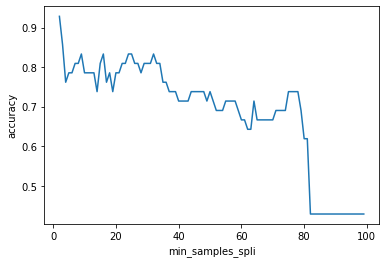

In [30]:
data = pd.DataFrame(list(zip(ix,accuracy_)), columns=['min_samples_spli', 'accuracy'])
sns.lineplot(x='min_samples_spli', y="accuracy", data=data)

In [31]:
data.head(10) #highets accuracy is provided by min_samples_split = 2

,min_samples_spli,accuracy
0,2,0.928571
1,3,0.857143
2,4,0.761905
3,5,0.785714
4,6,0.785714
5,7,0.809524
6,8,0.809524
7,9,0.833333
8,10,0.785714
9,11,0.785714


*# min_samples_leaf*

In [32]:
accuracy_ = []
ix = []
for i in range(1, 100):
    model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=i)
    ix.append(i)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy_.append(accuracy_score(y_test, y_pred))

<AxesSubplot:xlabel='# min_samples_leaf', ylabel='accuracy'>

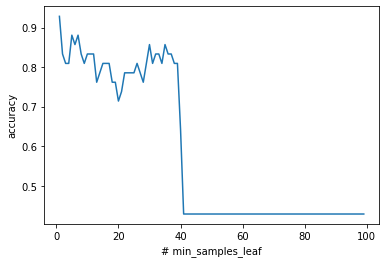

In [33]:
data = pd.DataFrame(list(zip(ix,accuracy_)), columns=['# min_samples_leaf', 'accuracy'])
sns.lineplot(x='# min_samples_leaf', y="accuracy", data=data)

In [34]:
data.head(10) #highets accuracy is provided by # min_samples_leaf = 1

,# min_samples_leaf,accuracy
0,1,0.928571
1,2,0.833333
2,3,0.809524
3,4,0.809524
4,5,0.880952
5,6,0.857143
6,7,0.880952
7,8,0.833333
8,9,0.809524
9,10,0.833333


The final model for Round 1:
- RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=1)

#### Round 2 - increasing number of trees

*n_estimators*

In [35]:
model = RandomForestClassifier(n_estimators=33, random_state=42, criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9047619047619048

Increase in the number of trees resulted in lower accuracy, so we stop and would measure performance on validation set.

#### Validation

In [36]:
model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
accuracy_score(y_val, y_pred)

0.8095238095238095

The accuracy on validation set is ~81% which is lower vs. on train set.

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

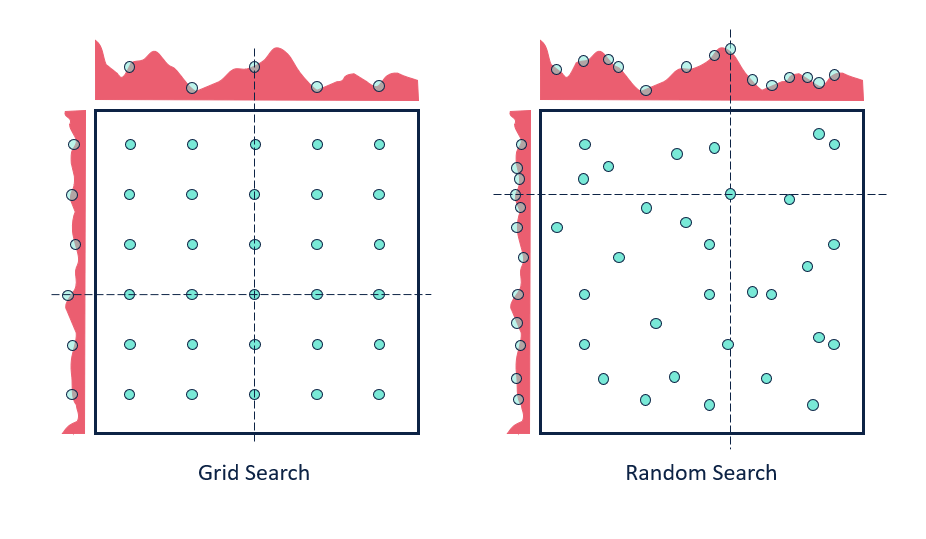

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [50]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 4)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 4)]

In [55]:
min_samples_leaf

[1, 4, 7, 10]

In [56]:
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
gr = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
gr.fit(x_train, y_train)
df = pd.DataFrame(gr.cv_results_)

In [58]:
gr.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [60]:
model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_depth=5, min_samples_split=4, min_samples_leaf=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
accuracy_score(y_val, y_pred)

0.8333333333333334

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [66]:
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
rd = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                        param_distributions = param_grid,
                        n_iter = 50, 
                        cv = 3, 
                        verbose=2, 
                        random_state=42)
rd.fit(x_train, y_train)
df_rd = pd.DataFrame(rd.cv_results_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=7, min_samples_split=10, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=7, min_samples_split=10, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=7, min_samples_split=10, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=55; total time=   0.0s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=55; total time=   0.0s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=55; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=2, n_estimators=77; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=2, n_estimators=77; total ti

[CV] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=32; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=32; total time=   0.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=7, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=7, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=7, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=7, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=7, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_sam

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=2, n_estimators=77; total time=   0.2s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=2, n_estimators=77; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=7, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=7, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=7, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=5, min

In [67]:
rd.best_params_

{'n_estimators': 32,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'entropy'}

In [68]:
model = RandomForestClassifier(n_estimators=32, random_state=42, criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=4)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
accuracy_score(y_val, y_pred)

0.8809523809523809

**Comparison with previous attempts**

RandomSearch resulted in highest accuracy for validation dataset (88%) vs. GridSearch(83%) and manual 'greedy' hyperparameter tuning of RandomForestClassifier model (80%). And it was the fastest as well.

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

- *Manual 'greedy' hyperparameter tuning of RandomForestClassifier model* was a good exersice to learn about parameters of the model, model behaviour and sensitivity of the model to parameters changes. It was the most time consiming approach as it was fully manual. Still we can automate, while as it is ine-time exersice I do not thing it would be the best idea.

-  *Grid search* experience was not really good, as my computer went crazy because of it :)

- The most promising experiense was with Random Search from run time perspective and easiness to define. Also it helped to obtain the highest accuracy. 

- In my experiment, the randomized search and the grid search exploreed exactly the same space of parameters. The result in parameter settings is high accuracy, while the run time for randomized search is drastically lower.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [96]:
import os
from sklearn.tree import DecisionTreeClassifier
PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [97]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [98]:
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])
data.loc[[62, 830], 'Embarked'] = 'C'
data['Age'] = data['Age'].fillna(data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))

In [99]:
columnsToEncode = ['Embarked', 'Sex', 'Pclass']
data = pd.get_dummies(data, columns=columnsToEncode, drop_first=True)

In [100]:
## 80-20 split
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Survived'), data['Survived'], 
                                                    test_size=0.2, random_state=42)

In [101]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 4)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 4)]

In [102]:
param_grid_ = {'splitter': splitter,
              'criterion': criterion,
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
rd_ = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                        param_distributions = param_grid_,
                        n_iter = 50, 
                        cv = 3, 
                        verbose=0, 
                        random_state=42)
rd_.fit(x_train, y_train)
df_rd_ = pd.DataFrame(rd_.cv_results_)

In [105]:
rd_.best_params_

{'splitter': 'random',
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_depth': 5,
 'criterion': 'gini'}

In [106]:
model = DecisionTreeClassifier(splitter='random', random_state=42, criterion='gini', max_depth=5, min_samples_split=10, 
                               min_samples_leaf=7)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8044692737430168

In [115]:
feat_names = x_train.columns
feat_names

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S', 'Sex_male',
       'Pclass_2', 'Pclass_3'],
      dtype='object')

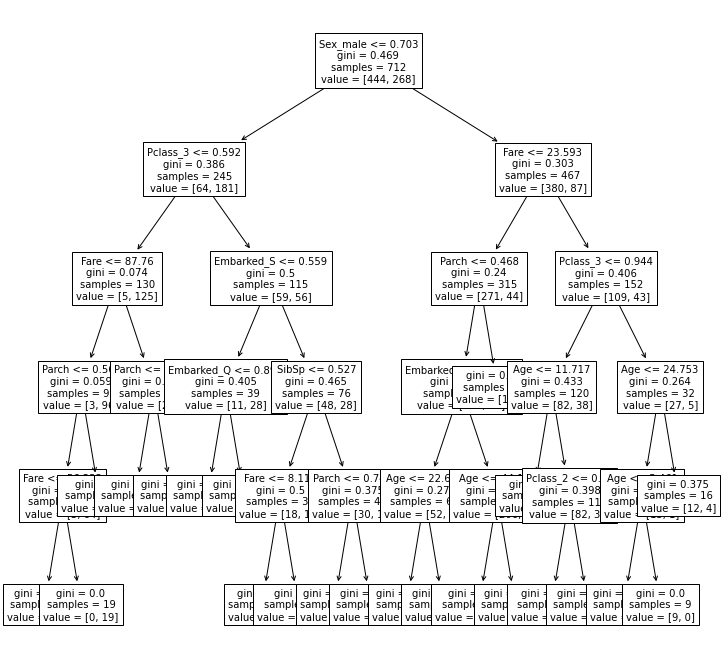

In [116]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(model, max_depth=6, fontsize=10, feature_names=feat_names)
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

Decision tree is an interesting approach to predict survival of a passenger on Titanic. I would suggest to use this model as a part of EDA to prioritize features and to touch them. For me it is not quite easy to interpret the decision tree to explain to a random person why would she/he survive / die on Titanic. Maybe it is better to start with a model with less number of features to make it easy to interpret. 